In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def get_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    data = data.drop(columns=["Adj Close"])
    data = data.drop(columns=["Volume"])
    
    return data.dropna()


In [32]:

def signal(data,atr_threshold=3):

    data['MA'] = data['Close'].rolling(window=20).mean()
    prev_close = data['Close'].shift(1)
    true_range = np.maximum(data['High'] - data['Low'], 
                            np.maximum(abs(data['High'] - prev_close), 
                                       abs(data['Low'] - prev_close)))
    data['ATR'] = true_range.rolling(window=14).mean()
    change = data['Close'].diff()
    gain = (change.where(change > 0, 0)).rolling(window=14).mean()
    loss = -1*(change.where(change < 0, 0)).rolling(window=14).mean()
    data['RSI'] = 100 - (100 / (1 + (gain / loss)))
   

    data['Signal'] = 0
    for i in range(1, len(data)):
        if (data['Close'].iloc[i] > data['MA'].iloc[i] and
        data['ATR'].iloc[i] > atr_threshold 
            and data['RSI'].iloc[i] < 70):
            data.loc[data.index[i], 'Signal'] = 1
        elif (data['Close'].iloc[i] < data['MA'].iloc[i] and
        data['ATR'].iloc[i] > atr_threshold 
              and data['RSI'].iloc[i] > 30):
            data.loc[data.index[i], 'Signal'] = -1
    return data




[*********************100%***********************]  1 of 1 completed

Maximum Drawdown Ratio: 14.22%
Strategy Returns: 4750.32%
Buy and Hold Returns: 853.75%


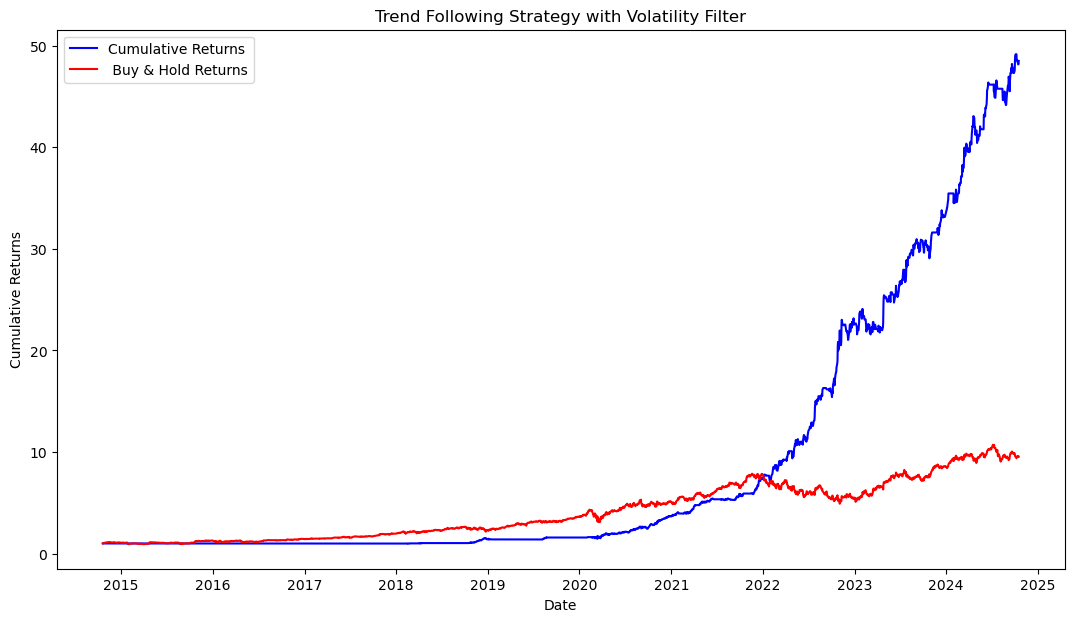

                  Open        High         Low       Close          MA  \
Date                                                                     
2014-10-17   43.200001   43.939999   42.790001   43.630001         NaN   
2014-10-20   43.060001   44.139999   42.810001   44.080002         NaN   
2014-10-21   44.360001   44.980000   44.189999   44.880001         NaN   
2014-10-22   45.000000   45.070000   44.230000   44.380001         NaN   
2014-10-23   44.619999   45.450001   44.529999   45.020000         NaN   
...                ...         ...         ...         ...         ...   
2024-10-10  415.230011  417.350006  413.149994  415.839996  425.711998   
2024-10-11  416.140015  417.130005  413.250000  416.320007  424.998499   
2024-10-14  417.769989  424.040009  417.519989  419.140015  424.388499   
2024-10-15  422.179993  422.480011  415.260010  418.739990  423.567999   
2024-10-16  415.170013  416.359985  410.480011  416.119995  422.833499   

                 ATR        RSI  Sign

In [34]:
def backtest(data):
    data['Market_Returns'] = data['Close'].pct_change()
    data['Strat_Returns']= data['Signal']*data['Market_Returns']
    data['C_Returns'] = (1 + data['Strat_Returns']).cumprod() 
    data['bh_Returns'] = (1 + data['Market_Returns']).cumprod()

    return data

def graph(data):
    plt.figure(figsize=(13, 7))

    plt.plot(data['C_Returns'], label='Cumulative Returns', color='blue')
    plt.plot(data['bh_Returns'], label=' Buy & Hold Returns', color='red')
    plt.title('Trend Following Strategy with Volatility Filter')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()
        

if __name__ == "__main__":
    ticker = 'MSFT' 
    start = '2014-10-17'
    end = '2024-10-17'

    data = get_data(ticker, start, end)
    
    data = signal(data)
    data = backtest(data)

    strategy_returns = (data['C_Returns'].iloc[-1] - 1) * 100
    buy_hold_returns = (data['bh_Returns'].iloc[-1] - 1) * 100

    #Drawdown Calulation
    max = data['C_Returns'].cummax()
    
    drawdowns = (max - data['C_Returns']) / max
    max_drawdown = drawdowns.max()  
    max_drawdown_ratio = max_drawdown * 100  

    print(f"Maximum Drawdown Ratio: {max_drawdown_ratio:.2f}%")

    print(f"Strategy Returns: {strategy_returns:.2f}%")
    print(f"Buy and Hold Returns: {buy_hold_returns:.2f}%")
    
    graph(data)
    print(data)
